7/15 (Fri)

---

# Completing Depth image by Combination model

### Objective

- Using generating model, complete depth image

In [1]:
import os
from pathlib import Path
import json
from datetime import datetime
from PIL import Image
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam

from utils.data import load_kitti_depth_dataset, show_image
from utils.segnet import SegNetEncoder, SegNetDecoder
from utils.segnet_basic import SegNetBasic
from utils.segnet import SegNet
from utils.train import Trainer
from utils.early_stop import EarlyStopper

from DeepLiDAR.submodels.depthCompleNew import depthCompletionNew, depthCompletionNew2

In [2]:
LOAD_DIR = Path("/home/matsuura/Development/waseda/m1/lecture_spring_2022/cgo/group_work/dataset/depth_selection")
SAVE_DIR = Path("/home/matsuura/Development/waseda/m1/lecture_spring_2022/cgo/group_work/results/depth/ray_results")
SAVE_DIR.mkdir(exist_ok=True, parents=True)

In [3]:
BATCH_SIZE = 4

### 1. Load data

In [4]:
train_dataset, val_dataset = load_kitti_depth_dataset(LOAD_DIR, train=True)

loading train & validation data: 0it [00:00, ?it/s]

In [5]:
color_example, sensor_example, mask_example, label_example = train_dataset[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


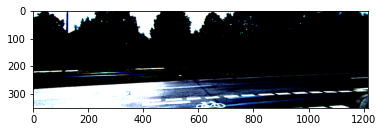

<Figure size 432x288 with 0 Axes>

In [6]:
ax = show_image(color_example)

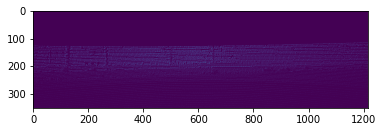

<Figure size 432x288 with 0 Axes>

In [7]:
ax = show_image(sensor_example)

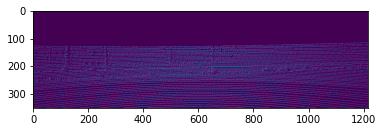

<Figure size 432x288 with 0 Axes>

In [8]:
ax = show_image(mask_example)

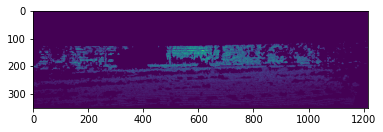

<Figure size 432x288 with 0 Axes>

In [9]:
ax = show_image(label_example)

### 2. Prepare Model

#### 2.1 Loading boundary encoder

In [10]:
boundary_generator_path = Path("/home/matsuura/Development/waseda/m1/lecture_spring_2022/cgo/group_work/results/segmentation/ray_results/20220715_20-24-14/checkpoint_model.pt")

# boundary_generator = SegNetBasic(**boundary_generator_params)
boundary_generator = SegNet(3, 3)
boundary_generator.load_state_dict(torch.load(boundary_generator_path))

boundary_encoder = boundary_generator.encoder

# Freezing weights
for params in boundary_encoder.parameters():
    params.requires_grad = False

In [11]:
z_boundary, _, _ = boundary_encoder(train_dataset.X[0:1])
z_boundary.shape

torch.Size([1, 512, 11, 38])

#### 2.2 Loading surface normal encoder

In [12]:
def adaptative_cat(out_conv, out_deconv, out_depth_up):
    out_deconv = out_deconv[:, :, :out_conv.size(2), :out_conv.size(3)]
    out_depth_up = out_depth_up[:, :, :out_conv.size(2), :out_conv.size(3)]
    return torch.cat((out_conv, out_deconv, out_depth_up), 1)

In [13]:
class SurfaceNormalEncoder(depthCompletionNew2):
    def __init__(self, bs) -> None:
        super().__init__(bs)

    def encode(self, left, sparse, mask):
        inputS = torch.cat((sparse,mask),1)
        inputS_conv = self.convS(inputS)
        inputS_conv0 = self.convS0(inputS_conv)
        inputS_conv1 = self.convS1(inputS_conv0)
        inputS_conv2 = self.convS2(inputS_conv1)
        inputS_conv3 = self.convS3(inputS_conv2)
        inputS_conv4 = self.convS4(inputS_conv3)

        input = self.conv1(left)
        out_conv2 = self.conv2(input)
        out_conv3 = self.conv3_1(self.conv3(out_conv2))
        out_conv4 = self.conv4_1(self.conv4(out_conv3))
        out_conv5 = self.conv5_1(self.conv5(out_conv4))
        out_conv6 = self.conv6_1(self.conv6(out_conv5))+inputS_conv4

        return out_conv6

In [14]:
deeplidar_params = torch.load("/home/matsuura/Development/waseda/m1/lecture_spring_2022/cgo/group_work/depth_completion_KITTI.tar")

deeplidar = depthCompletionNew(BATCH_SIZE)
deeplidar = nn.DataParallel(deeplidar, device_ids=[0])
deeplidar.load_state_dict(deeplidar_params["state_dict"])

surface_normal_generator = deeplidar.module.normal

In [15]:
surface_normal_encoder = SurfaceNormalEncoder(BATCH_SIZE)
surface_normal_encoder.load_state_dict(surface_normal_generator.state_dict())

for params in surface_normal_encoder.parameters():
    params.requires_grad = False

In [16]:
z_normal = surface_normal_encoder.encode(train_dataset.X[0:1], train_dataset.X_sensor[0:1], train_dataset.X_mask[0:1])
z_normal.shape

torch.Size([1, 512, 11, 38])

In [17]:
class CombinationDepthGenerator(nn.Module):
    def __init__(self, n_channel_depth=1, n_out_depth=1, bn_momentum=0.1):
        super().__init__()
        self.sensor_depth_encoder = SegNetEncoder(n_channel_depth, bn_momentum)
        self.depth_decoer = SegNetDecoder(n_out_depth, bn_momentum)

    def forward(
        self,
        Z_boundary,
        Z_normal,
        X_sensor
    ):
        z_sensor, pooling_indices, pooling_size = self.sensor_depth_encoder(X_sensor)

        z = Z_normal + Z_boundary + z_sensor

        y = self.depth_decoer(z, pooling_indices, pooling_size)

        return y

### 3. Preparing for training

In [23]:
class DepthGeneratorTrainer(Trainer):
    def train_batch(
        self,
        batch,
        model,
        optimizer,
        criterion
    ):
        X_color, X_sensor, X_mask, Y = batch
        X_color = X_color.float()
        X_sensor = X_sensor.float()
        X_mask = X_mask.float()

        optimizer.zero_grad()

        Z_boundary = boundary_encoder(X_color)[0]
        Z_normal = surface_normal_encoder.encode(X_color, X_sensor, X_mask)

        Z_boundary = Z_boundary.to(self.device)
        Z_normal = Z_normal.to(self.device)
        X_sensor = X_sensor.to(self.device)
        Y = Y.to(self.device).float()

        preds = model(
            Z_boundary,
            Z_normal,
            X_sensor
        )

        loss = criterion(preds, Y)
        loss.backward()

        optimizer.step()

        return loss

In [24]:
def evaluate(model, val_dataset, losses, device):
    model.to(device)
    model.eval()

    total_mse = 0
    for i in range(0, len(val_dataset), BATCH_SIZE):
        X_color, X_sensor, X_mask, Y = val_dataset[i:i + BATCH_SIZE]
        Z_boundary = boundary_encoder(X_color)[0]
        Z_normal = surface_normal_encoder.encode(X_color, X_sensor, X_mask)

        Z_boundary = Z_boundary.to(device)
        Z_normal = Z_normal.to(device)
        X_sensor = X_sensor.to(device)
        Y = Y.to(device)
    
        preds = model(
            Z_boundary, 
            Z_normal,
            X_sensor
        )

        mse = F.mse_loss(preds, Y, reduction="sum")
        total_mse += mse.to("cpu")
    
    mse = total_mse / 200

    ax = plt.subplot()
    ax.plot(
        list(range(len(losses))),
        losses
    )
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    plt.savefig("loss.png")
    plt.clf()

    ax_origin = show_image(X_color[0], show=False)
    plt.savefig("val_origin.png")
    plt.clf()

    ax_label = show_image(Y.to("cpu")[0], show=False)
    plt.savefig("val_label.png")
    plt.clf()

    ax_pred = show_image(preds.to("cpu")[0], show=False)
    plt.savefig("val_pred.png")
    plt.clf()

    return mse

In [25]:
def train_evaluation(config, options):
    save_dir = SAVE_DIR / datetime.now().strftime("%Y%m%d_%H-%M-%S")
    save_dir.mkdir(parents=True, exist_ok=True)
    os.chdir(save_dir)

    model = CombinationDepthGenerator(
        **config["params"]
    )

    optimizer = Adam(
        model.parameters(),
        lr=config["lr"],
        weight_decay=config["weight_decay"]
    )

    criterion = nn.MSELoss()

    early_stopper = options["early_stopper"]

    epoch, batch_size = config["epoch"], config["batch_size"]

    trainer = DepthGeneratorTrainer(device=options["device"])
    losses = trainer.train(
        model, optimizer, criterion,
        options["train_dataset"], epoch, batch_size,
        early_stopper=early_stopper, verbose=options["verbose"],
        **options["params"]
    )

    mse = evaluate(
        model, options["val_dataset"], losses, options["device"]
    )

    metrics = {
        "MSE": mse
    }

    with open("params.json", "w") as f:
        json.dump(config, f)

    for key, val in metrics.items():
        print(f"{key}:\t{val:.03f}")

### 4. Experiment

In [26]:
config = {
    "batch_size": BATCH_SIZE,
    "epoch": 300,
    "lr": 0.002,
    "weight_decay": 0.0002,
    "params": {
        "n_channel_depth": 1, 
        "n_out_depth": 1,
        "bn_momentum": 0.1
    }
}

options = {
    "early_stopper": EarlyStopper(patience=5, verbose=True),
    "verbose": True,
    "device": "cuda:0",
    "params": {},
    "train_dataset": train_dataset,
    "val_dataset": val_dataset
}

In [27]:
train_evaluation(config, options)

training:   0%|          | 0/300 [00:00<?, ?it/s]